In [1]:
include("F:/Tue/Thesis/codes/GP_CVI/BayesianUtilities-main/BayesianUtilities-main/BayesianUtilities.jl")
using Distributions, LinearAlgebra, Plots, Random, .BayesianUtilities, Zygote
using DataStructures: Queue, enqueue!, dequeue!
using Flux.Optimise
using CSV, DataFrames

In [2]:
include("F:/Tue/Thesis/codes/GP_CVI/normal GP.jl") # remember to change the path 
include("F:/Tue/Thesis/codes/GP_CVI/optimize_normal_GP.jl") # remember to change the path

optim_gp_adam (generic function with 2 methods)

In [3]:
data = CSV.read("F:\\Tue\\Thesis\\codes\\GP_CVI\\Covid_RIVM.csv",DataFrame, delim=";");

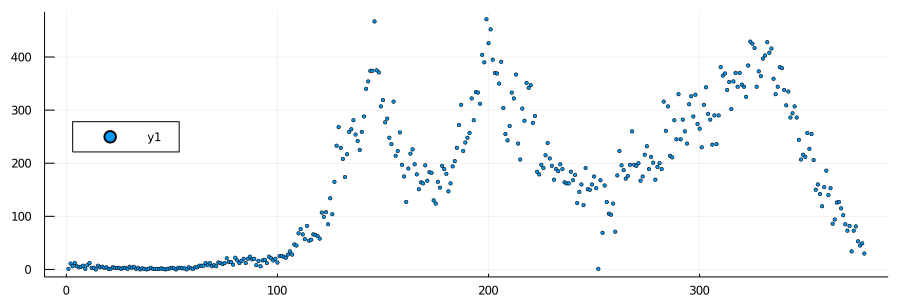

In [4]:
observation = Float64.(data.Tested_positive)
T = length(observation)
scatter(observation, markersize=2, size = (900, 300), legend = :left)

# Model Specification

In [5]:
# Newtonian dynamics assumption
A = [1. 1.; 0. 1.]
B = [1. 0.]

# Priors
p_z_init = MvNormal(zeros(2),diagm(0=>ones(2)))
#p_W = Wishart(2,diagm(0=>ones(2)))
W = diagm(0=>ones(2))

# Non-conjugate loglikelihood function
function log_likelihood(y,z)
    x = exp((B*z)[1]) # B*z returns 1 dimensional array
    logpdf(Poisson(x),y)
end

log_likelihood (generic function with 1 method)

# Inference

In [6]:
# CVI message towards z
function approx_message_z(obs::Real,mes_income::MvNormal,η::Real,n_its::Int)
    opt = ADAM(η)
    q = mes_income # initialize variational distribution with closed form incoming message
    _, _, λ_q, _, _ = exp_family(q) # initial variational parameters
    λ_m = zeros(6) # initial message parameters
    violation = 0 # keep track of number of updates lead to invalid parameters 
    λ_m_latest = Queue{Vector}()
    for n=1:n_its
        logp(z) = log_likelihood(obs,z)
        grad = cvi(logp,q) # grad estimates
        update!(opt,λ_m,λ_m - grad)
        λ_q = λ_q .+ λ_m # update variational parameters
        try
            q = exp_family(MvNormal, λ_q) # update q
        catch
            λ_q = λ_q .- λ_m # avoid updates that violate the support of Gaussian
            violation += 1
            @show violation
        end
    end
    return λ_m # return approximate message parameters
end

approx_message_z (generic function with 1 method)

In [121]:
#use normal GP
function filter_GP(W, T)
    uncertainty_1 = []; #store uncertainty of the 1st element
    uncertainty_3 = []; #store uncertainty of the 2nd element
    GP_train_size = []; #store the size of training set after updating
    count_new = 0; #count the number of new added observations = number of samples needs cvi
    count_gp = 0; #count the number of samples that we use gp

    forward_estimates = Array{MvNormal}(undef, T)
    λ_m = approx_message_z(observation[1],p_z_init,0.2,10000);   
    _, _, λ_p, _, _ = exp_family(p_z_init);
    gp_input = vcat(λ_p, observation[1]); #this is our input
    gp_output = λ_m; #this is our output
    forward_estimates[1] = collide(p_z_init,Canonical(MvNormal, λ_m));
    ### Collect the first 25 samples for GP
    for t=2:25
        predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Matrix(Hermitian(inv(W))));
        #start collecting data for Gp
         _, _, λ_pre, _, _ = exp_family(predict);
        temp = vcat(λ_pre,observation[t]); # use this variable to store new input
        gp_input = hcat(gp_input, temp); # collect new input data for GP
        
        λ_m = approx_message_z(observation[t],predict,0.2,10000);
        gp_output = hcat(gp_output,λ_m); # collect output for GP
        forward_estimates[t] = collide(predict,Canonical(MvNormal, λ_m));
    end
    
    ### Train GP
    #optimal parameters of the first output element
    σ1_op, l1_op,llh1 = optim_gp(gp_input, gp_output[1,:], 2., [0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.], 1e-4, 1000); 
    #σ1_op,l1_op,llh1 = optim_gp_adam(gp_input, gp_output[1,:],2.,[0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.],1e-4,5,2600)
    #optimal parameters of the third output element
    σ3_op, l3_op,llh3 = optim_gp(gp_input, gp_output[3,:], 2., [0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.], 1e-4, 800); 
    #σ3_op,l3_op,llh3 = optim_gp_adam(gp_input, gp_output[3,:],2.,[0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.],1e-4,5,1000)
    @show llh1
    @show llh3
    ### Use GP to predict the rest
    for t=26:T
        predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Matrix(Hermitian(inv(W))));
        _, _, λ_pre, _, _ = exp_family(predict);
        temp = vcat(λ_pre,observation[t]); # new point

        λ_m_1,var_1 = gp_predict(gp_input,gp_output[1,:],temp,σ1_op,l1_op); #Predict
        λ_m_3,var_3 = gp_predict(gp_input,gp_output[3,:],temp,σ3_op,l3_op); #Predict
        
        uncertainty_1 = append!(uncertainty_1,var_1[1])
        uncertainty_3 = append!(uncertainty_3,var_3[1])
        #check uncertainty, if greater than pre-defined threshold, then collect new data
        if var_1[1] >= .5 && var_3[1] >= .5
            λ_m = approx_message_z(observation[t],predict,0.2,10000); #use CVI
            gp_input = hcat(gp_input,temp); #observe new input
            gp_output = hcat(gp_output,λ_m); #observe new output
            count_new += 1;
            if count_new == 100
                #optimal parameters of the first output element
                σ1_op,l1_op,llh1 = optim_gp_adam(gp_input, gp_output[1,:],2.,[0.005, 0.25, 0.18, 0.26, 0.14, 0.02, 4.],1e-3,25,2100) 
                #optimal parameters of the third output element
                σ3_op,l3_op,llh3 = optim_gp_adam(gp_input, gp_output[3,:],2.,[0.005, 0.25, 0.18, 0.26, 0.14, 0.02, 4.],1e-3,25,2100)
                @show llh1
               @show llh3
                @show t
                @show count_new
                @show count_gp
                count_new = 0;
                count_gp = 0;
            end

        else
            count_gp += 1;
            λ_m = [λ_m_1[1],0,λ_m_3[1],0,0,0]; #use GP's result
        end
        
        if t==T
            @show count_gp
        end
        GP_train_size = append!(GP_train_size,size(gp_input,2))
        #@show λ_m
        forward_estimates[t] = collide(predict,Canonical(MvNormal, λ_m));
    end
    
    return forward_estimates, uncertainty_1, uncertainty_3, GP_train_size
end

function filter_CVI(W, T)
    forward_estimates = Array{MvNormal}(undef, T)
    λ_m = approx_message_z(observation[1],p_z_init,0.2,10000)   
    forward_estimates[1] = collide(p_z_init,Canonical(MvNormal, λ_m))
    for t=2:T
        predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Matrix(Hermitian(inv(W))))
        λ_m = approx_message_z(observation[t],predict,0.2,10000)
        forward_estimates[t] = collide(predict,Canonical(MvNormal, λ_m))
    end
    return forward_estimates
end

function smooth(forward_estimates,W, T)
    smooth_estimates = Array{MvNormal}(undef, T)
    smooth_estimates[T] = forward_estimates[T]
    joint_dists = Array{MvNormal}(undef, T-1)
    for t=T-1:-1:1
        smooth_estimates[t], joint_dists[t] = transit(forward_estimates[t],smooth_estimates[t+1],A,W)
    end
    return smooth_estimates, joint_dists
end
;

### Use GP

In [140]:
@time begin
forward_estimates,uncer_1, uncer_3, training_size = filter_GP(W,T)
smooth_estimates_GP, joint_dists_GP = smooth(forward_estimates, W, T)
end
;

llh1 = 23.049507002287122
llh3 = -0.9117225804315714
llh1 = 177589.0322626429
llh3 = 1856.6940644911363
t = 223
count_new = 100
count_gp = 98
count_gp = 128
 76.541358 seconds (259.64 M allocations: 19.598 GiB, 4.71% gc time)


### use CVI

In [130]:
@time begin
forward_estimates = filter_CVI(W,T)
smooth_estimates_CVI, joint_dists_CVI = smooth(forward_estimates, W, T)
end
;

124.346046 seconds (434.82 M allocations: 30.136 GiB, 5.72% gc time)


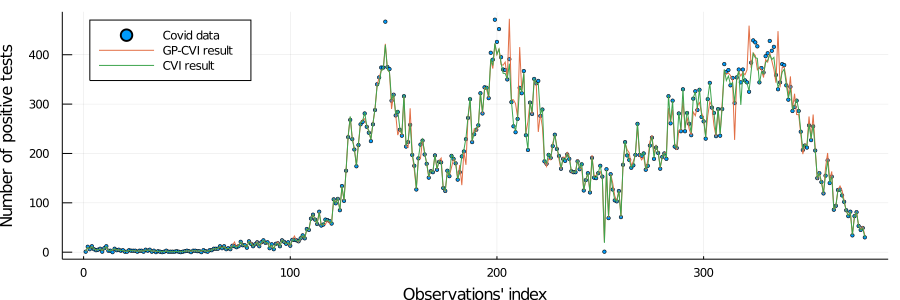

In [158]:
state1_est_GP = zeros(T)
state1_est_CVI = zeros(T)

for t=1:T
    state1_est_GP[t] = mean(smooth_estimates_GP[t])[1]
    state1_est_CVI[t] = mean(smooth_estimates_CVI[t])[1]
end

scatter(observation,markersize=2, size = (900, 300),label = "Covid data")
plot!(exp.(state1_est_GP),label = "GP-CVI result", legend = :topleft, 
    ylabel = "Number of positive tests", xlabel = "Observations' index", left_margin = 3Plots.mm, bottom_margin = 3Plots.mm)
plot!(exp.(state1_est_CVI),label = "CVI result")
#xlabel!("Observations' index")
#ylabel!("Number of positive tests")


In [150]:
#savefig("F:\\Tue\\Thesis\\codes\\GP_CVI\\result_test1.png")

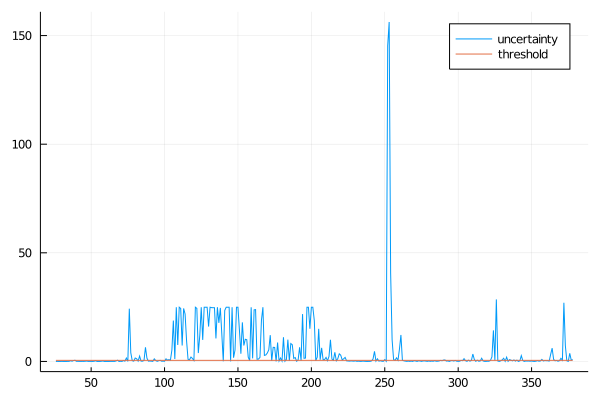

In [159]:
#plot uncertainty
plot(26:T,uncer_1, label = "uncertainty")
plot!(26:T,0.5.*ones(length(26:T)),label = "threshold")


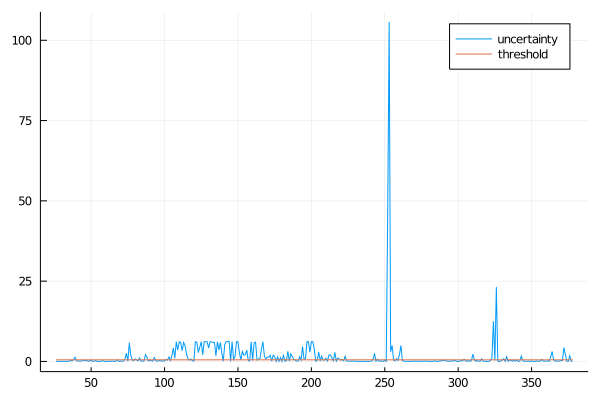

In [160]:
#plot uncertainty
plot(26:T,uncer_3,label = "uncertainty")
plot!(26:T,0.5.*ones(length(26:T)),label = "threshold")


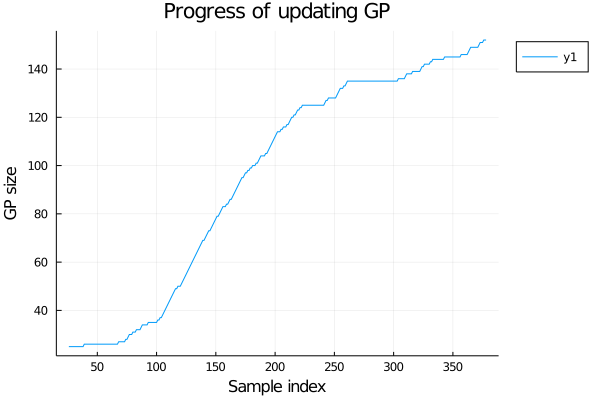

In [161]:
plot(26:T,training_size, legend = :outertopright)
xlabel!("Sample index")
ylabel!("GP size")
title!("Progress of updating GP")

In [162]:
println("Total number of times we use CVI: $(training_size[end])")  #number of times we use CVI

Total number of times we use CVI: 152


In [163]:
println("Total number of times we use GP: $(T - training_size[end])")   #number of times we use GP

Total number of times we use GP: 226
